## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

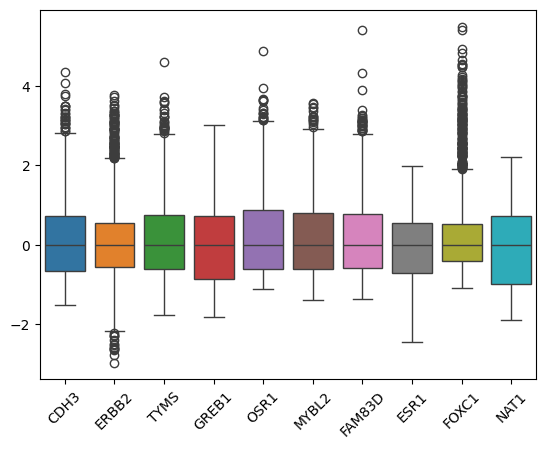

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

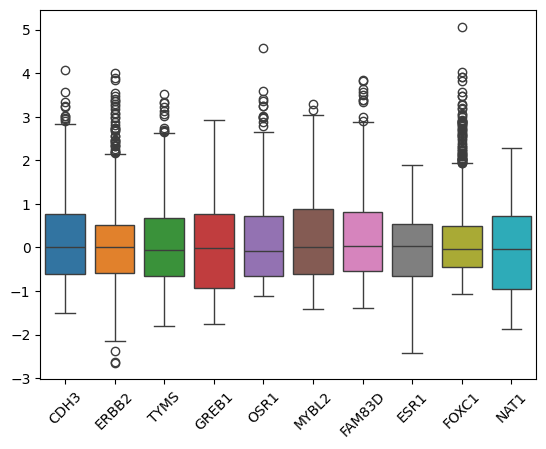

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

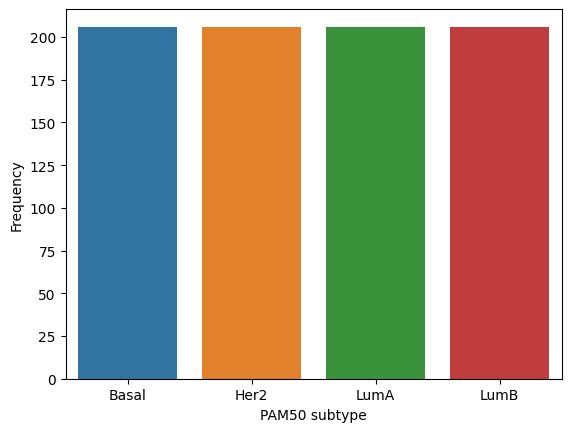

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = MLPClassifier(random_state = 42, max_iter = 10000, early_stopping = True)
precision = make_scorer(precision_score, average = 'macro', zero_division = 0)
recall = make_scorer(recall_score, average = 'macro', zero_division = 0)

scoring = {"accuracy" : "accuracy",
           "precision" : precision,
           "recall" : recall,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = scoring, return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = scoring, return_train_score = True)

In [11]:
print("Mean train accuracy (original) =", np.mean(origianl_score["train_accuracy"]), "±", np.std(origianl_score["train_accuracy"]))
print("Mean validation accuracy (original) =", np.mean(origianl_score["test_accuracy"]), "±", np.std(origianl_score["test_accuracy"]), "\n")
print("Mean train precision (original) =", np.mean(origianl_score["train_precision"]), "±", np.std(origianl_score["train_precision"]))
print("Mean validation precision (original) =", np.mean(origianl_score["test_precision"]), "±", np.std(origianl_score["test_precision"]), "\n")
print("Mean train recall (original) =", np.mean(origianl_score["train_recall"]), "±", np.std(origianl_score["train_recall"]))
print("Mean validation recall (original) =", np.mean(origianl_score["test_recall"]), "±", np.std(origianl_score["test_recall"]), "\n")
print("Mean train F1-score (original) =", np.mean(origianl_score["train_f1-score"]), "±", np.std(origianl_score["train_f1-score"]))
print("Mean validation F1-score (original) =", np.mean(origianl_score["test_f1-score"]), "±", np.std(origianl_score["test_f1-score"]), "\n")
print("Mean train AUROC (original) =", np.mean(origianl_score["train_auc"]), "±", np.std(origianl_score["train_auc"]))
print("Mean validation AUROC (original) =", np.mean(origianl_score["test_auc"]), "±", np.std(origianl_score["test_auc"]), "\n")

Mean train accuracy (original) = 0.8963613597350637 ± 0.011719919082207614
Mean validation accuracy (original) = 0.8892767480369639 ± 0.02504658303108888 

Mean train precision (original) = 0.8911348218994699 ± 0.01281041984540168
Mean validation precision (original) = 0.8831754432282828 ± 0.030164943498319597 

Mean train recall (original) = 0.877773456077741 ± 0.016290683802084257
Mean validation recall (original) = 0.8683107975933387 ± 0.03373982662108818 

Mean train F1-score (original) = 0.8840325668107945 ± 0.014647120459037237
Mean validation F1-score (original) = 0.8735258609910257 ± 0.031231550477083293 

Mean train AUROC (original) = 0.9809709713666039 ± 0.0041940059793585
Mean validation AUROC (original) = 0.9788933887749274 ± 0.008117490223748013 



In [12]:
print("Mean train accuracy (undersampled) =", np.mean(undersample_score["train_accuracy"]), "±", np.std(undersample_score["train_accuracy"]))
print("Mean validation accuracy (undersampled) =", np.mean(undersample_score["test_accuracy"]), "±", np.std(undersample_score["test_accuracy"]), "\n")
print("Mean train precision (undersampled) =", np.mean(undersample_score["train_precision"]), "±", np.std(undersample_score["train_precision"]))
print("Mean validation precision (undersampled) =", np.mean(undersample_score["test_precision"]), "±", np.std(undersample_score["test_precision"]), "\n")
print("Mean train recall (undersampled) =", np.mean(undersample_score["train_recall"]), "±", np.std(undersample_score["train_recall"]))
print("Mean validation recall (undersampled) =", np.mean(undersample_score["test_recall"]), "±", np.std(undersample_score["test_recall"]), "\n")
print("Mean train F1-score (undersampled) =", np.mean(undersample_score["train_f1-score"]), "±", np.std(undersample_score["train_f1-score"]))
print("Mean validation F1-score (undersampled) =", np.mean(undersample_score["test_f1-score"]), "±", np.std(undersample_score["test_f1-score"]), "\n")
print("Mean train AUROC (undersampled) =", np.mean(undersample_score["train_auc"]), "±", np.std(undersample_score["train_auc"]))
print("Mean validation AUROC (undersampled) =", np.mean(undersample_score["test_auc"]), "±", np.std(undersample_score["test_auc"]), "\n")

Mean train accuracy (undersampled) = 0.8691346108376894 ± 0.012152391822359372
Mean validation accuracy (undersampled) = 0.8567895974140463 ± 0.03853343005185676 

Mean train precision (undersampled) = 0.8735713027636698 ± 0.009486998616172762
Mean validation precision (undersampled) = 0.8656874585809325 ± 0.03736518481071668 

Mean train recall (undersampled) = 0.8691369514675966 ± 0.012147322091726538
Mean validation recall (undersampled) = 0.8570416666666667 ± 0.03851131181923758 

Mean train F1-score (undersampled) = 0.8688258209292665 ± 0.01297732592507032
Mean validation F1-score (undersampled) = 0.8558338171233884 ± 0.03922475331264906 

Mean train AUROC (undersampled) = 0.9783780320818859 ± 0.0029060037064152907
Mean validation AUROC (undersampled) = 0.9751022837920644 ± 0.011218748270191519 



###  Hyperparameter tuning using GridSearchCV

In [13]:
hyperparameters = {'hidden_layer_sizes': [(5), (15), (32), (64), (96), (128), (5, 10), (10, 15), (32, 64), (64, 64), (64, 128)],
                   'learning_rate' : ['constant', 'adaptive', 'invscaling']} 

clf = MLPClassifier(random_state = 42, max_iter = 10000, early_stopping = True)
optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = -1, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [14]:
print('가장 좋은 hidden_layer_sizes:', best_model.best_estimator_.get_params()['hidden_layer_sizes'])
print('가장 좋은 learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print("가장 좋은 Score :", best_model.best_score_)

가장 좋은 hidden_layer_sizes: (64, 64)
가장 좋은 learning_rate: constant
가장 좋은 Score : 0.8959841888787992


In [15]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_precision', 'std_train_precision', 'mean_test_precision', 'std_test_precision',
                  'mean_train_recall', 'std_train_recall', 'mean_test_recall', 'std_test_recall',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
params,"{'hidden_layer_sizes': (64, 64), 'learning_rat...","{'hidden_layer_sizes': (64, 64), 'learning_rat...","{'hidden_layer_sizes': (64, 64), 'learning_rat...","{'hidden_layer_sizes': (32, 64), 'learning_rat...","{'hidden_layer_sizes': (32, 64), 'learning_rat...","{'hidden_layer_sizes': (32, 64), 'learning_rat...","{'hidden_layer_sizes': (64, 128), 'learning_ra...","{'hidden_layer_sizes': (64, 128), 'learning_ra...","{'hidden_layer_sizes': (64, 128), 'learning_ra...","{'hidden_layer_sizes': 96, 'learning_rate': 'i...",...,"{'hidden_layer_sizes': (5, 10), 'learning_rate...","{'hidden_layer_sizes': 32, 'learning_rate': 'i...","{'hidden_layer_sizes': 32, 'learning_rate': 'a...","{'hidden_layer_sizes': 32, 'learning_rate': 'c...","{'hidden_layer_sizes': 15, 'learning_rate': 'i...","{'hidden_layer_sizes': 15, 'learning_rate': 'a...","{'hidden_layer_sizes': 15, 'learning_rate': 'c...","{'hidden_layer_sizes': 5, 'learning_rate': 'ad...","{'hidden_layer_sizes': 5, 'learning_rate': 'in...","{'hidden_layer_sizes': 5, 'learning_rate': 'co..."
mean_train_accuracy,0.906601,0.906601,0.906601,0.906109,0.906109,0.906109,0.90326,0.90326,0.90326,0.898264,...,0.885296,0.885365,0.885365,0.885365,0.885468,0.885468,0.885468,0.868042,0.868042,0.868042
std_train_accuracy,0.009676,0.009676,0.009676,0.008229,0.008229,0.008229,0.012568,0.012568,0.012568,0.012279,...,0.018872,0.014729,0.014729,0.014729,0.013083,0.013083,0.013083,0.021121,0.021121,0.021121
mean_test_accuracy,0.895984,0.895984,0.895984,0.894075,0.894075,0.894075,0.891495,0.891495,0.891495,0.890671,...,0.879526,0.879423,0.879423,0.879423,0.878548,0.878548,0.878548,0.862405,0.862405,0.862405
std_test_accuracy,0.020527,0.020527,0.020527,0.019285,0.019285,0.019285,0.021975,0.021975,0.021975,0.023352,...,0.025107,0.025884,0.025884,0.025884,0.0231,0.0231,0.0231,0.030026,0.030026,0.030026
mean_train_precision,0.905247,0.905247,0.905247,0.902954,0.902954,0.902954,0.902732,0.902732,0.902732,0.893188,...,0.883401,0.884302,0.884302,0.884302,0.882342,0.882342,0.882342,0.86362,0.86362,0.86362
std_train_precision,0.008041,0.008041,0.008041,0.008198,0.008198,0.008198,0.010846,0.010846,0.010846,0.010982,...,0.01656,0.008963,0.008963,0.008963,0.011608,0.011608,0.011608,0.019474,0.019474,0.019474
mean_test_precision,0.894487,0.894487,0.894487,0.891078,0.891078,0.891078,0.891175,0.891175,0.891175,0.886201,...,0.878612,0.87945,0.87945,0.87945,0.876569,0.876569,0.876569,0.858832,0.858832,0.858832
std_test_precision,0.023725,0.023725,0.023725,0.025676,0.025676,0.025676,0.026361,0.026361,0.026361,0.026931,...,0.026398,0.028332,0.028332,0.028332,0.028588,0.028588,0.028588,0.034946,0.034946,0.034946
mean_train_recall,0.887653,0.887653,0.887653,0.885666,0.885666,0.885666,0.883069,0.883069,0.883069,0.876288,...,0.862926,0.84897,0.84897,0.84897,0.873436,0.873436,0.873436,0.805701,0.805701,0.805701


### Model evaluation using hyperparameter

In [16]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.91      0.90      0.91        92
        Her2       0.87      0.83      0.85        89
        LumA       0.91      0.92      0.92       450
        LumB       0.81      0.81      0.81       200

    accuracy                           0.88       831
   macro avg       0.88      0.87      0.87       831
weighted avg       0.88      0.88      0.88       831



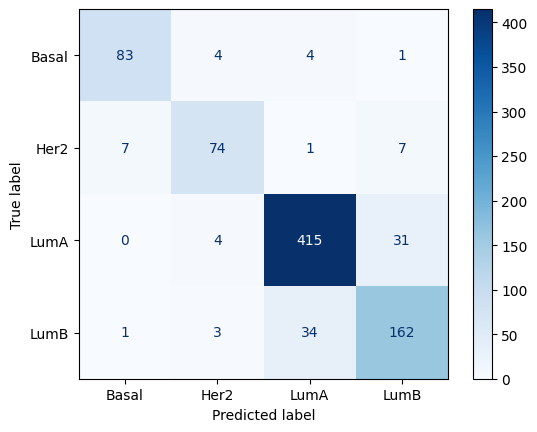

In [18]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

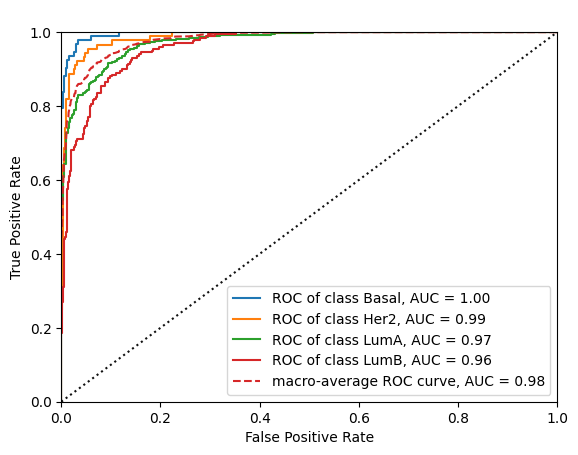

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

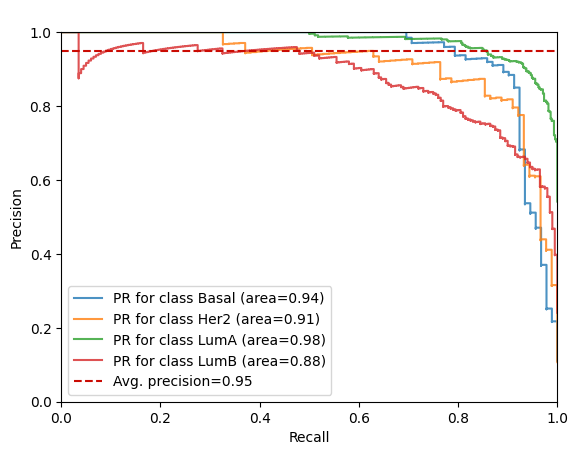

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [20]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

In [21]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8832731648616126

In [22]:
# Macro average precision
precision_score(y_test, y_pred, average = "macro")

0.8756858032338302

In [23]:
# Macro average recall
recall_score(y_test, y_pred, average = "macro")

0.8664642023557511

In [24]:
# Macro average F1 score
f1_score(y_test, y_pred, average = "macro")

0.8709500451439889

In [25]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9797918498480246